In [301]:
#import packages
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date 
import seaborn as sns
from matplotlib import pyplot as plt

import duckdb, sqlalchemy

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Research Questions

1. Is there a significant difference between historical weather trends when moving about 100 miles away from a central location?
2. Is it possible to accurately model and predict the weather based on another location’s weather?
3. Does latitude, longitude, or elevation have the most significant impact on temperature? On precipitation?
4. How does proximity to a lake impact historical trends? Is there a significant difference between the variation in temperature or precipitation for Erie and Ithaca compared to the other locations?



## Data Cleaning



We obtained our data through 3 data requests to weather.gov. First, we requested Ithaca's data, and then we decided to expand out analysis to include locations north, east, south, and west of Ithaca. Our second data pull included the following cities: Watertown (North), Bloomsburg (South), Cobleskill (East), and Avoca (West). Avoca did not contain any temperature data, so we decided to request data for Erie as a replacement. The cell below, reads in the csv files obtained from weather.gov.

In [302]:
#read in csvs
ithaca = pd.read_csv("Ithaca.csv")
others = pd.read_csv("AdjacentCities.csv")
west = pd.read_csv("Erie.csv")
#print(ithaca.head())
#print(west.head())
others = others.dropna(axis=0,subset=['STATION'])
#print(others.head())

C:\Users\Margaret Quirk\AppData\Local\Temp\ipykernel_18428\1485939667.py:2: DtypeWarning: Columns (9,15,17,19,21,27,29,31,33,35,37,39,41,47) have mixed types. Specify dtype option on import or set low_memory=False.
  ithaca = pd.read_csv("Ithaca.csv")
C:\Users\Margaret Quirk\AppData\Local\Temp\ipykernel_18428\1485939667.py:3: DtypeWarning: Columns (27,29,31,33,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  others = pd.read_csv("AdjacentCities.csv")
C:\Users\Margaret Quirk\AppData\Local\Temp\ipykernel_18428\1485939667.py:4: DtypeWarning: Columns (7,9,11,13,15,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81) have mixed types. Specify dtype option on import or set low_memory=False.
  west = pd.read_csv("Erie.csv")


Since certain locations contained multiple weather stations, we created the column Location to group the entries as shown in the cell below.

In [303]:
#Add column to indicate location (relative to ithaca)
ithaca["Location"] = "Central"
west['Location'] = "West"
#print(others['NAME'].unique())
locations = []
for i in others['NAME']:
    if "WATERTOWN" in i:
        locations.append('North')
    elif "BLACK RIVER" in i:
        locations.append("North")
    elif "ESPY" in i:
        locations.append("South")
    elif "BLOOMSBURG" in i:
        locations.append("South")
    elif "COBLESKILL" in i:
        locations.append("East")
    else:
        locations.append('N/A')
others['Location'] = locations
print(others['Location'].unique())


['North' 'South' 'East']


Certain cities had more data attributes available than others, so to maintain cohesion, the cell below identifies common columns between the three data sets. We then dropped any uncommon columns and concatenated the three datasets to form one dataframe containing all relevant data.

In [304]:
#Check all columns match before concatenation
columns_to_keep = []

for i in ithaca.columns.tolist():
    if (i in others.columns.tolist()) & (i in west.columns.tolist()) :
        columns_to_keep.append(i)
ithaca_good = ithaca[columns_to_keep]
others_good = others[columns_to_keep]
west_good = west[columns_to_keep]
        
if (ithaca_good.columns.tolist() == others_good.columns.tolist()) & (ithaca_good.columns.tolist() == west_good.columns.tolist()):
    print("Columns match: proceed")
    final_df = pd.concat([ithaca_good,others_good,west_good])
else:
    print(ithaca.columns)
    print(others.columns)
    
#print(final_df)

Columns match: proceed


In the cell below, we checked to make sure that none of the columns contained only null values. All columns contained at least one relevant datapoint, but if this was not the case, we also included code that would drop an entirely null column.

In [305]:
#Check for null values in columns
print(final_df.columns)
#If a column has only null values, drop the column
null_cols = []
for c in final_df.columns:
    if final_df[c].isnull().all():
        null_cols.append(c)
if len(null_cols) == 0:
    print("No null columns")
else:
    print('Null columns:', null_cols)
    final_df = final_df.drop(null_cols)

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'DAPR',
       'DAPR_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES',
       'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TMAX',
       'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES',
       'WESF', 'WESF_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES', 'Location'],
      dtype='object')
No null columns


The attributes columns in the weather.gov data contains a string that contains multiple attribute indicators concatenated together. "Trace" is an attribute that we believe will be relevant to our analysis and is represented by a "T" in the attribute columns. We used this to create new binary columns that indicate whether or not there was a trace of precipitation or snow on a given day.

In [306]:
#Create binary columns to indicate if there was trace of precipitation for snow and rain
precip_binary = []
snow_binary = []
for p in final_df['PRCP_ATTRIBUTES']:
    #print(type(p))
    if (type(p) == str):
        if 'T' in p:
            precip_binary.append(1)
        else:
            precip_binary.append(0)
    else:
        precip_binary.append(0)
        
for s in final_df['SNOW_ATTRIBUTES']:
    if (type(s) == str):
        if 'T' in s:
            snow_binary.append(1)
        else:
            snow_binary.append(0)
    else:
        snow_binary.append(0)
    
final_df['PrecipTrace'] = precip_binary
final_df['SnowTrace'] = snow_binary

With the addition of the binary columns, we no longer need the initial attributes columns and drop them from the dataframe below.

In [307]:
#Drop attributes columns now that we have created the binary columns
final_df = final_df.drop(columns = ['PRCP_ATTRIBUTES', 'SNOW_ATTRIBUTES'])

In addition, we converted the data column to datetime.

In [308]:
#Convert date column to datetime
final_df['DATE'] = pd.to_datetime(final_df['DATE'], format = '%m/%d/%Y')
#print(final_df['DATE'])

In some cases, there were multiple stations within the same location category that recorded data. To account for this, we created an aggregated dataframe that groups by location and date and takes the average of the temperature, location, elevation, and precipitation data. This aggregated dataframe takes the maximum of the binary columns to indicate if there was a trace anywhere within the location. We wanted to maintain the binary property of the columns in order to perform logistic regression in the final phase of the project.

In [309]:
#Aggregate dataframe to account for locations with multiple stations taking recordings on the same day
%sql agg_df << select DATE, Location, avg(LATITUDE) as Latitude, avg(LONGITUDE) as Longitude, avg(ELEVATION) as Elevation, AVG(TMAX) as MaxTemp, AVG(TMIN) as MinTemp,AVG(PRCP) as Precipitation, AVG(SNOW) as Snowfall, MAX(PrecipTrace) as PrecipTrace, MAX(SnowTrace) as SnowTrace from final_df group by Location, DATE order by DATE
agg_df['AverageTemp'] = 0.5*agg_df['MaxTemp'] + 0.5*agg_df['MinTemp']

agg_df['Month_Grouping'] = agg_df['DATE'].dt.to_period('M')
agg_df['Month_Grouping'] = agg_df['Month_Grouping'].astype('datetime64[M]')
#print(agg_df[['DATE','Month Grouping']])

Returning data to local variable agg_df


We also split the aggregated dataframe into smaller dataframes based on location.

In [310]:
#Create 5 separate data frames based on location for individual analyses when needed
central = agg_df[agg_df['Location']=="Central"]
north = agg_df[agg_df['Location']=="North"]
south = agg_df[agg_df['Location']=="South"]
east = agg_df[agg_df['Location']=="East"]
west = agg_df[agg_df['Location']=="West"]

## Data Description

Each row in this dataset is a date ranging from 2000 to 2022, and location, which is either Ithaca, Bloomsburg, Erie, Watertown, or Cobleskill. The data was received in three separate files, as the National Weather Service sends one file for each request. First Ithaca data was requested to test the data quality, and understand attributes provided. Then 4 more cities were requested, and were provided in one file. However, one of these cities was missing temperature data, so we chose to request a different city, thus resulting in a third file. We then combined these files to include 5 cities with Ithaca at the center. The columns in this data set are as follows: 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'DAPR',  'DAPR_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES',  'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TMAX',  'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES', 'WESF', 'WESF_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES', 'Location', 'Precip Trace', and 'Snow Trace'.  The dataset created by combining cities has 71,144 rows and 27 columns.

This dataset was created as a record of past observable weather events, and is used to predict future events, and train models. The data comes from the National Weather Service, which is a federally funded agency, whose job is to provide weather forecasts and other weather information, including data, in the public domain. The National Weather Service uses their own remote sensing equipment as well as working with some local weather stations to collect data. Therefore, the data was directly observable through the use of weather hardware apparatuses including thermometers, rain gauges, snow boards, and yardsticks. Since these tools were used, people and surveying were not involved in this data creation. Depending on the equipment available in the areas chosen to be analyzed, some of the null columns may exist because the proper tools to record such an observation were not available. Meanwhile, other null values may have occurred because there was not a reliable weather station in the chosen locations at a certain time, since all the locations are relatively rural. Some of the preprocessing that occurred is data filtering to only include observations in the desired locations, and quantitative attributes for various weather conditions, such as snow or rain, being added based on corresponding columns. 


Raw data source
Ithaca data: https://drive.google.com/file/d/1nqrr9H8sJTQJVXNlwPeIdXmr4nBxcg7M/view?usp=sharing 
Other city data: https://drive.google.com/file/d/19-Uf3W-ls7k7-OtloUc4hNisYEYgmxmf/view?usp=sharing 
Erie data: https://drive.google.com/file/d/1kqY8DdBSWfDtdshsmF35hZYGRaoIHsY3/view?usp=sharing 
 


## Data Limitations

Null values: The most consistent quantitative observations available for each location and date are temperature, elevation, precipitation, and snowfall. However, there are many other columns containing other types of observations, which have a significant amount of null values. This may make it hard to incorporate these other observations if there is not enough data, and could lead to a less accurate model. At this time we are still including these other attributes in the dataset, but we recognize that they may have to be excluded later.

Different length of time frames: Five cities are included in this analysis and new dataset, however different amounts of data exist for each city. Ideally 20 years of history would be included for each city, however this was not available, so there is less data to use to train a model for certain cities, which could impact accuracy of results. 

Limited scope of cities: Only a total of 5 cities are included in this dataset, so conclusions from this analysis are not necessarily applicable to other areas. This is especially true because this dataset is centered around Ithaca, which is a Northeastern climate, however in a desert setting the results to these research questions likely will not be applicable based on this analysis.

Attributes are not very descriptive: The attributes for different weather events are not very descriptive. This could make it difficult to incorporate the attribute columns into an analysis as it is unclear what some of the different attributes mean, especially in the context of the research questions.

Missing temperature data: For Bloomsburg, which is the city South of Ithaca chosen, temperature data is missing for many years. This is an issue because temperature is one of the most consistent columns in other cities, so it is critical to analysis. However, there are not many major cities in the radius since Ithaca is in a relatively rural setting, so finding another city with better data was not a possibility. This will make predictions over time difficult when including Bloomsburg, and we may have to limit the scope to timeframes with complete data.


## Exploratory Data Analysis

For the first stage of our exploratory data analysis, we printed the summary statistics for the dataframe containing all the regions and the summary statistics for each region individually. Overall, the statistics appear similar across the regions. The Southern region appears to be slightly warmer compared to the rest, and the snowfall is highest in the North. In the following phases, we plan on exploring further into seasonality and how it affects the summary statistics and trends.

In [311]:
#Summary statistics for each region
agg_list = [central, north, south, east, west]
title_list = ['Central', 'North', 'South', 'East','West']
print('All Regions')
print(round(agg_df[['MaxTemp','MinTemp','Precipitation','Snowfall','AverageTemp']].describe(),3))
print()
for i in range(0,5,1):
    print(title_list[i])
    print(round(agg_list[i][['MaxTemp','MinTemp','Precipitation','Snowfall','AverageTemp']].describe(),3))
    print()

All Regions
         MaxTemp    MinTemp  Precipitation   Snowfall  AverageTemp
count  34006.000  33645.000      34784.000  32645.000    33599.000
mean      57.259     38.860          0.122      0.232       48.044
std       20.271     18.931          0.271      1.070       19.226
min      -10.000    -44.000          0.000      0.000      -19.500
25%       40.000     26.000          0.000      0.000       33.500
50%       59.000     39.000          0.003      0.000       49.000
75%       75.000     55.000          0.117      0.000       64.500
max       98.000     80.000          5.270     25.000       88.000

Central
        MaxTemp   MinTemp  Precipitation  Snowfall  AverageTemp
count  8265.000  8265.000       8281.000  8290.000     8265.000
mean     57.118    37.478          0.111     0.181       47.298
std      20.336    18.008          0.259     0.787       18.801
min       0.000   -22.000          0.000     0.000      -10.000
25%      40.000    25.000          0.000     0.000      

The cell below produces 5 subplots of daily average temperature throughout 2017. We chose 2017 as it was the most recent year in which all regions had a substantial amount of temperature data. Our Southern region is missing a couple periods of temperature data within 2017, most notably in June. As expected, there is clear seasonality for each region.

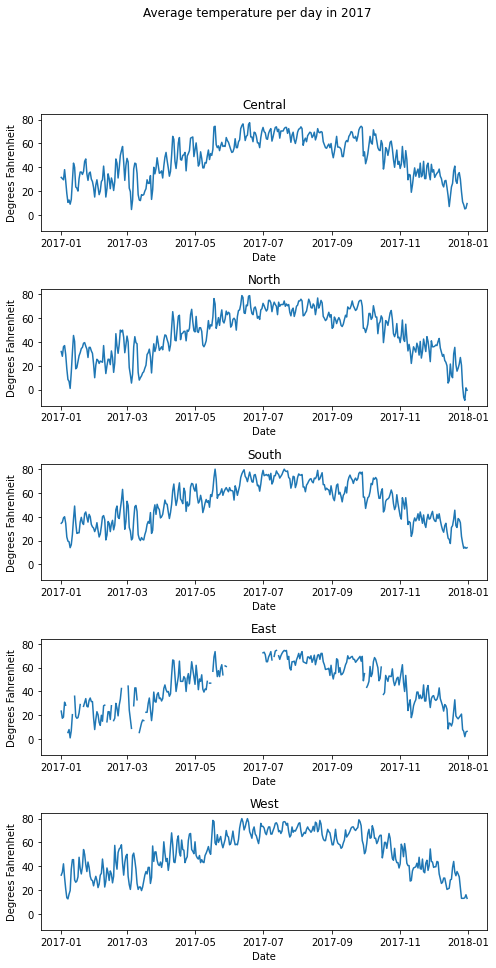

In [312]:
#temperature for sample year 2017
central_2017 = central[(central['DATE']>='2017-01-01')&(central['DATE']<= '2017-12-31')]
north_2017 = north[(north['DATE']>='2017-01-01')&(north['DATE']<= '2017-12-31')]
south_2017 = south[(south['DATE']>='2017-01-01')&(south['DATE']<= '2017-12-31')]
east_2017 = east[(east['DATE']>='2017-01-01')&(east['DATE']<= '2017-12-31')]
west_2017 = west[(west['DATE']>='2017-01-01')&(west['DATE']<= '2017-12-31')]

df_list = [central_2017, north_2017, south_2017, east_2017, west_2017]
fig, axs = plt.subplots(5, sharex = False, sharey=True, figsize = (8,15))
fig.suptitle('Average temperature per day in 2017')
fig.subplots_adjust(hspace = 0.5)
index = 0
title_list = ['Central', 'North', 'South', 'East','West']
for i in df_list:
    axs[index].plot(i['DATE'], i['AverageTemp'])
    axs[index].set_ylabel('Degrees Fahrenheit')
    axs[index].set_xlabel('Date')
    axs[index].set_title(title_list[index])
    index+=1

The code below creates a lineplot to compare average monthly temperature across the regions. It is incredibly difficult to distinguish between the regions which once again suggests the importance of breaking up the data by seasonality in future phases.

Returning data to local variable month_df


[Text(0.5, 1.0, 'Average Temperature by Month')]

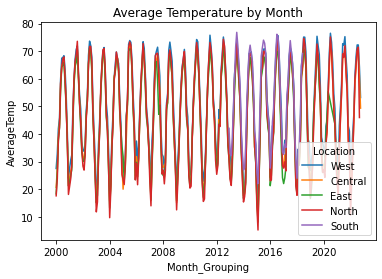

In [313]:
#line plot of temparature in each region over time
%sql month_df << select Month_Grouping, avg(AverageTemp) as AverageTemp, Location from agg_df group by Month_Grouping, Location order by Month_Grouping
sns.lineplot(x='Month_Grouping', y='AverageTemp', hue = 'Location', data = month_df).set(title = 'Average Temperature by Month')

The graph below shows a lineplot of total average annual rainfall across each of the regions. It is important to note that the Southern region did not begin collecting rainfall data until the end of 2011. It also appears that the Eastern region stopped collecting rainfall data in 2021.

Returning data to local variable precip_df


[Text(0.5, 1.0, 'Total Rainfall by Year in Inches')]

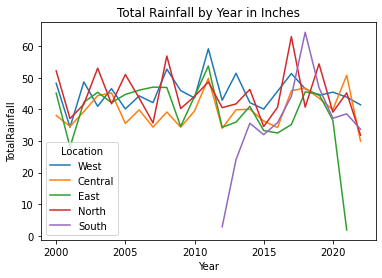

In [314]:
#Comparison of annual rainfall 
agg_df['Year'] = agg_df['DATE'].dt.year
%sql precip_df << select Year, Location, sum(Precipitation) as TotalRainfall, sum(Snowfall) as TotalSnowfall from agg_df group by Year, Location order by Year
precip_df['TotalPrecipitation'] = precip_df['TotalRainfall'] + precip_df['TotalSnowfall']
sns.lineplot(x='Year', y='TotalRainfall', hue = 'Location', data = precip_df).set(title = 'Total Rainfall by Year in Inches')

The graph below shows a lineplot of total average annual snowfall across each of the regions. Once again, the Southern region did not begin collecting snowfall data until the end of 2011, and it seems that the Eastern region stopped collecting data in 2021. In this plot, the Northern and Western region seem to have considerably higher snowfall levels compared to the other regions.

[Text(0.5, 1.0, 'Total Snowfall by Year in Inches')]

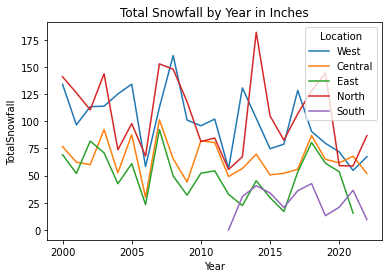

In [315]:
#Comparison of annual snowfall
sns.lineplot(x='Year', y='TotalSnowfall', hue = 'Location', data = precip_df).set(title = 'Total Snowfall by Year in Inches')

The plot below shows total annual precipitation across each region. The Northern and Western have the highest precipitation levels as expected due to the snowfall plot.

[Text(0.5, 1.0, 'Total Precipitation by Year in Inches')]

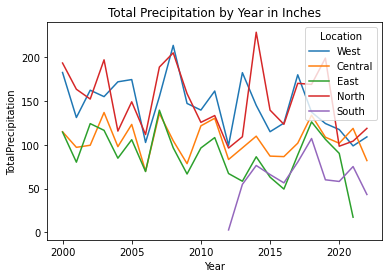

In [316]:
#Comparison of annual precipitation
sns.lineplot(x='Year', y='TotalPrecipitation', hue = 'Location', data = precip_df).set(title = 'Total Precipitation by Year in Inches')

Finally, we ran some summary statistics on the Trace columns for each region since we plan to conduct a logistic regression with these variables in the following phase. It is interesting to note that the Eastern region has a high number of trace observations despite having one of the lowest annual precipitation totals. 

In [319]:
#Summary statistics for trace observations
for i in range(0,5,1):
    print(title_list[i])
    temp_df = round(agg_list[i][['PrecipTrace', 'SnowTrace']].describe(),3)
    print(temp_df.head(3))
    print()

Central
       PrecipTrace  SnowTrace
count     8290.000   8290.000
mean         0.162      0.100
std          0.368      0.299

North
       PrecipTrace  SnowTrace
count     8244.000   8244.000
mean         0.085      0.061
std          0.279      0.240

South
       PrecipTrace  SnowTrace
count     2502.000   2502.000
mean         0.060      0.039
std          0.238      0.193

East
       PrecipTrace  SnowTrace
count     7533.000   7533.000
mean         0.098      0.089
std          0.297      0.284

West
       PrecipTrace  SnowTrace
count     8325.000   8325.000
mean         0.225      0.112
std          0.418      0.315



## Questions for reviewers

1. Should we replace the city we chose as our Southern location in order to obtain a more complete dataset?
2. Are our research questions complex enough? Can we revise them in later phases based on our findings?
3. Are there any techniques that we haven't learned in class yet that you think will be useful in our analysis?